In [1]:
from dotenv import load_dotenv
load_dotenv()
import os
fred_api_key = os.getenv(".env")
import fredapi as fr
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns 
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.preprocessing import MinMaxScaler
from src.config import load_config
from src.logger import logger
from src.data import Fred_Data
config = load_config()
fred_data = Fred_Data(api_key=fred_api_key,series_ids=config['series_ids'])
fred_data = fred_data.fetch_data()
df = fred_data.get_dataframe()
device = "cuda:0" if torch.cuda.is_available() else "cpu"
print(device)



cuda:0


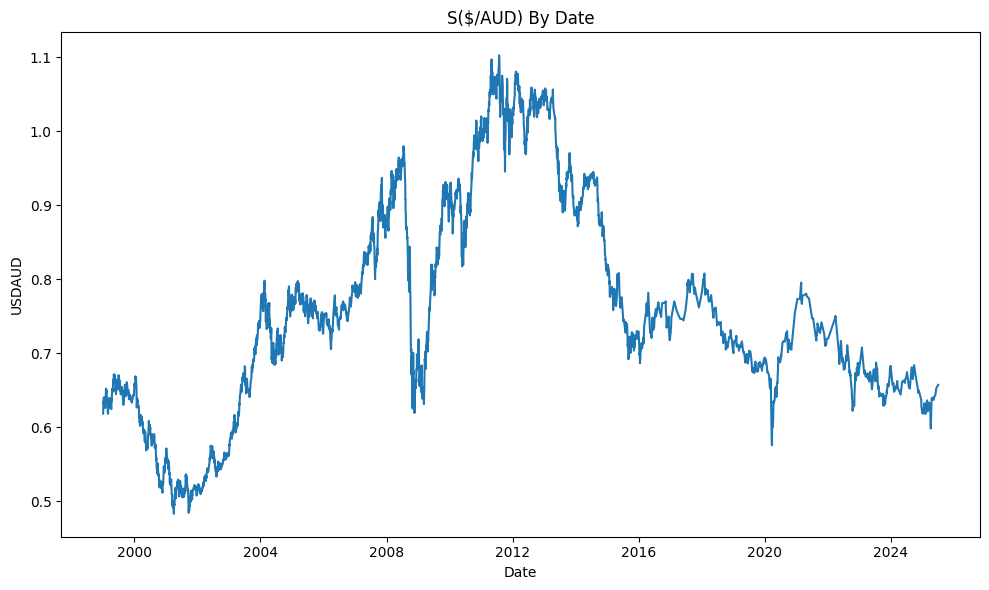

In [2]:
"""USDAUD"""

df = df['USDAUD']
df.drop_duplicates(inplace=True)
df = df.reset_index()
df['Date'] = df['index']
df.drop('index',axis=1,inplace=True)

plt.figure(figsize=(10,6))
sns.lineplot(x='Date',y='USDAUD',data=df)
plt.title("S($/AUD) By Date")
plt.savefig("images/spotrate-USDAUD.png")
plt.tight_layout()
plt.show()



In [3]:
training = df.iloc[:,0:1].values
train_size = int(len(training) * .90)


train_data = training[:train_size]
test_data = training[train_size:]


scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_data)
test_scaled = scaler.transform(test_data)







def slider(data,seq_length):
    X,y = [],[]
    for i in range(len(data) - seq_length - 1):
        Xi = data[i:(i+seq_length)]
        yi = data[(i+seq_length)]
        X.append(Xi)
        y.append(yi)
        
    return np.array(X),np.array(y)

seq_length = 6

X_train,y_train = slider(train_scaled,seq_length)
X_test,y_test = slider(test_scaled,seq_length)

X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).float()

X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).float()


class BiLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(BiLSTM, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.output_size = output_size
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_size * 2, output_size)

    def forward(self, X):
        h0 = torch.zeros(2 * self.num_layers, X.size(0), self.hidden_size)
        c0 = torch.zeros(2 * self.num_layers, X.size(0), self.hidden_size)
        out, _ = self.lstm(X, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out



bidirectional_lstm = BiLSTM(input_size=1,hidden_size=64,num_layers=2,output_size=1)
epochs = 500
learning_rate = 0.001
bilistm_optimizer = torch.optim.Adam(params=bidirectional_lstm.parameters(),lr=learning_rate)
loss_fn = nn.MSELoss()


for epoch in range(epochs):
    y_pred = bidirectional_lstm(X_train)
    loss = loss_fn(y_pred.float(),y_train)
    bilistm_optimizer.zero_grad()
    loss.backward()
    bilistm_optimizer.step()
    if epoch % 1 != 0:
        continue
    bidirectional_lstm.eval()
    with torch.no_grad():
        y_pred = bidirectional_lstm(X_train)
        train_rsme = np.sqrt(loss_fn(y_pred,y_train))
        y_pred_test =  bidirectional_lstm(X_test)
        test_rsme = np.sqrt(loss_fn(y_pred_test,y_test))
        print(f'Epoch: {epoch}; train_RSEM: {train_rsme:.4}; Test RSME: {test_rsme:.4}')

C:\Users\katsa\AppData\Local\Temp\ipykernel_15616\359808022.py:78: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  train_rsme = np.sqrt(loss_fn(y_pred,y_train))
C:\Users\katsa\AppData\Local\Temp\ipykernel_15616\359808022.py:80: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  test_rsme = np.sqrt(loss_fn(y_pred_test,y_test))


Epoch: 0; train_RSEM: 0.521; Test RSME: 0.2791
Epoch: 1; train_RSEM: 0.497; Test RSME: 0.2536
Epoch: 2; train_RSEM: 0.4729; Test RSME: 0.2278
Epoch: 3; train_RSEM: 0.4485; Test RSME: 0.2016
Epoch: 4; train_RSEM: 0.4235; Test RSME: 0.1745
Epoch: 5; train_RSEM: 0.3976; Test RSME: 0.1465
Epoch: 6; train_RSEM: 0.3707; Test RSME: 0.1176
Epoch: 7; train_RSEM: 0.3428; Test RSME: 0.08878
Epoch: 8; train_RSEM: 0.3141; Test RSME: 0.06405
Epoch: 9; train_RSEM: 0.2854; Test RSME: 0.05663
Epoch: 10; train_RSEM: 0.2583; Test RSME: 0.07849
Epoch: 11; train_RSEM: 0.2363; Test RSME: 0.119
Epoch: 12; train_RSEM: 0.2242; Test RSME: 0.1686
Epoch: 13; train_RSEM: 0.2267; Test RSME: 0.2216
Epoch: 14; train_RSEM: 0.2415; Test RSME: 0.2698
Epoch: 15; train_RSEM: 0.2573; Test RSME: 0.3029
Epoch: 16; train_RSEM: 0.2643; Test RSME: 0.3159
Epoch: 17; train_RSEM: 0.261; Test RSME: 0.3115
Epoch: 18; train_RSEM: 0.2504; Test RSME: 0.2946
Epoch: 19; train_RSEM: 0.2369; Test RSME: 0.2703
Epoch: 20; train_RSEM: 0.2242;

In [5]:
with torch.no_grad():
    pred = bidirectional_lstm(X_test)
    pred_np = pred.cpu().numpy()
    y_test_np = y_test.cpu().numpy()
    pred_rescaled = scaler.inverse_transform(pred_np)
    actual_rescaled = scaler.inverse_transform(y_test_np)



test_dates = df.iloc[train_size + seq_length: -1]['Date']


comparison_df = pd.DataFrame({
    "Date": test_dates,
    "Actual Spot Rate": actual_rescaled.flatten(),
    "Predicted Spot Rate":pred_rescaled.flatten()
})
print(comparison_df.head(20))
print(comparison_df.tail(20))

           Date  Actual Spot Rate  Predicted Spot Rate
3041 2019-08-21            0.6792             0.676031
3042 2019-08-22            0.6764             0.676659
3043 2019-08-23            0.6749             0.676130
3044 2019-08-27            0.6758             0.675785
3045 2019-08-28            0.6746             0.675409
3046 2019-08-29            0.6734             0.674826
3047 2019-08-30            0.6730             0.674009
3048 2019-09-05            0.6820             0.673132
3049 2019-09-06            0.6856             0.674940
3050 2019-09-10            0.6868             0.677367
3051 2019-09-12            0.6871             0.679678
3052 2019-09-13            0.6886             0.681830
3053 2019-09-18            0.6844             0.684107
3054 2019-09-19            0.6795             0.684873
3055 2019-09-24            0.6793             0.683568
3056 2019-09-25            0.6750             0.682161
3057 2019-10-03            0.6751             0.679722
3058 2019-

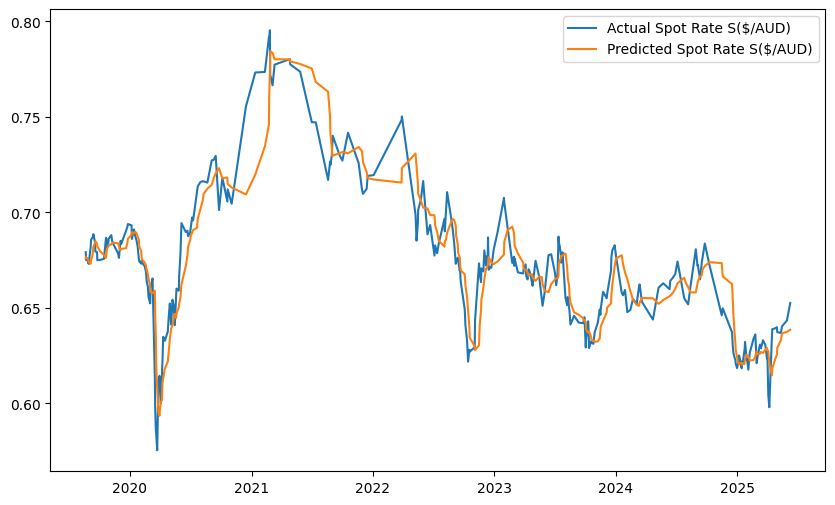

In [6]:
plt.figure(figsize=(10,6))
plt.plot(comparison_df['Date'],comparison_df["Actual Spot Rate"],label="Actual Spot Rate S($/AUD)")
plt.plot(comparison_df['Date'],comparison_df['Predicted Spot Rate'],label="Predicted Spot Rate S($/AUD)")
plt.legend()
plt.savefig("images/predicted_vs_actual-usd-aud.png")
plt.show()